<a href="https://colab.research.google.com/github/JoshOmondi/deep_learning/blob/master/NetflixRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### installing dependencies

In [1]:
!pip install -q sentence-transformers faiss-cpu transformers gradio




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 27.4 MB/s eta 0:00:00


### Importing libraries

In [2]:

import os
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
import faiss
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import pickle
import gradio as gr



### uploading the kaggle API key token


In [3]:
from google.colab import files
files.upload()


Saving kaggle (8).json to kaggle (8).json


{'kaggle (8).json': b'{"username":"joshua10542","key":"9dea666f96ee6bc8882112018583b046"}'}

### Configure kaggle and download the dataset

In [4]:
!mkdir -p ~/.kaggle
!cp "kaggle (8).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets list -s netflix


ref                                                            title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
netflix-inc/netflix-prize-data                                 Netflix Prize data                                   716193814  2019-11-13 18:39:37.417000         104006       1450  0.7647059        
shivamb/netflix-shows                                          Netflix Movies and TV Shows                            1400865  2021-09-27 04:44:36.770000         685953       9496  1.0              
imtkaggleteam/netflix                                          NetFlix                                                1224946  2023-11-05 08:01:21.163000           4103        104  1.0              
rohit

### download the netflix dataset

In [6]:
!kaggle datasets download -d shivamb/netflix-shows


Dataset URL: https://www.kaggle.com/datasets/shivamb/netflix-shows
License(s): CC0-1.0
  0% 0.00/1.34M [00:00<?, ?B/s]
100% 1.34M/1.34M [00:00<00:00, 644MB/s]


### unzipping the dataset

In [7]:
!unzip netflix-shows.zip -d data


Archive:  netflix-shows.zip
  inflating: data/netflix_titles.csv  


### testing the dataset

In [8]:
import pandas as pd
df = pd.read_csv("data/netflix_titles.csv")
df.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


### checking some basic info of the dataset

In [9]:
df.info()
df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
count,8807,8807,8807,6173,7982,7976,8797,8807.000000,8803,8804,8807,8807
unique,8807,2,8807,4528,7692,748,1767,NaN,17,220,514,8775
top,s8807,Movie,Zubaan,Rajiv Chilaka,David Attenborough,United States,"January 1, 2020",NaN,TV-MA,1 Season,"Dramas, International Movies","Paranormal activity at a lush, abandoned prope..."
freq,1,6131,1,19,19,2818,109,NaN,3207,1793,362,4
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014.180198,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.819312,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1925.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019.000000,NaN,NaN,NaN,NaN


In [10]:
#Parameter
# Data / files
CSV_PATH = "netflix_titles.csv"   # ensure this file is in /content or Colab root
INDEX_FILE = "netflix_faiss.index"
META_FILE = "netflix_metadata.pkl"

# Embedding model
EMBED_MODEL_NAME = "all-MiniLM-L6-v2"   # small, fast, high-quality embeddings

# Retriever
TOP_K = 5

# Generation model (choose a CPU-friendly model)
# Flan-T5 small is reasonable on CPU. For better quality use a larger model on GPU.
GEN_MODEL_NAME = "google/flan-t5-small"
GEN_MAX_LENGTH = 256
GEN_TEMPERATURE = 0.3

# Device for generation/inference
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)



Using device: cuda


#### Data loading and preprocessing

In [11]:
!ls


 data  'kaggle (8).json'   netflix-shows.zip   sample_data


In [12]:
!unzip netflix-shows.zip -d /content


Archive:  netflix-shows.zip
  inflating: /content/netflix_titles.csv  


In [13]:
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"{CSV_PATH} not found. Upload it to Colab or mount Drive.")

df = pd.read_csv(CSV_PATH)
# Quick preview
print(df.shape)
df.head(2)

(8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."


#### Prepare the text for the column

In [14]:

# Combine title + description (you can add cast, director, etc.)
df["text"] = (
    df["title"].fillna("") + " — " +
    df["description"].fillna("")
)
df.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,text
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",Dick Johnson Is Dead — As her father nears the...
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",Blood & Water — After crossing paths at a part...
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,Ganglands — To protect his family from a power...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...","Jailbirds New Orleans — Feuds, flirtations and..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,Kota Factory — In a city of coaching centers k...


#### clean the text

In [15]:
def clean(text):
    return text.replace("\n", " ").strip()

df["text"] = df["text"].apply(clean)


#### only keep useful columns

In [16]:
documents = df[["show_id", "title", "type", "text"]]
documents.head()


,show_id,title,type,text
0,s1,Dick Johnson Is Dead,Movie,Dick Johnson Is Dead — As her father nears the...
1,s2,Blood & Water,TV Show,Blood & Water — After crossing paths at a part...
2,s3,Ganglands,TV Show,Ganglands — To protect his family from a power...
3,s4,Jailbirds New Orleans,TV Show,"Jailbirds New Orleans — Feuds, flirtations and..."
4,s5,Kota Factory,TV Show,Kota Factory — In a city of coaching centers k...


In [17]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,text
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",Dick Johnson Is Dead — As her father nears the...
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",Blood & Water — After crossing paths at a part...
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,Ganglands — To protect his family from a power...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...","Jailbirds New Orleans — Feuds, flirtations and..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,Kota Factory — In a city of coaching centers k...


#### Converting data types

In [18]:

# Convert `date_added` to datetime
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# Extract new features
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

# Ensure release_year is integer
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce')

# Optional: Standardize rating categories
df['rating'] = df['rating'].replace({
    'UR': 'Unrated',
    'NR': 'Unrated'
})


#### Explaratory Data Analysis(EDA)

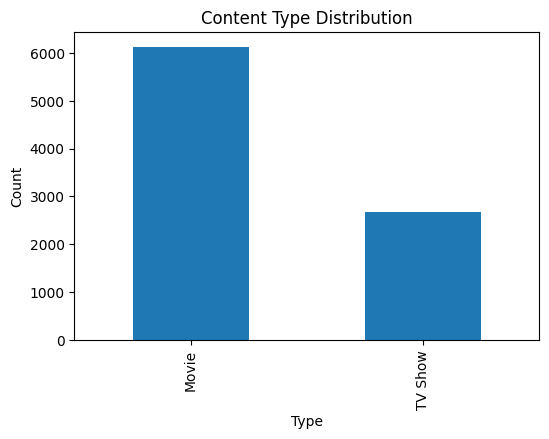

In [19]:
#Movies vs TV Shows count

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df['type'].value_counts().plot(kind='bar')
plt.title("Content Type Distribution")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()


In [20]:
#Top countries producing Netflix content

# Split the 'country' column into multiple rows
df_countries = df.assign(country=df['country'].str.split(', ')).explode('country')

top_countries = df_countries['country'].value_counts().head(10)
top_countries


,count
country,
United States,3689
India,1046
United Kingdom,804
Canada,445
France,393
Japan,318
Spain,232
South Korea,231
Germany,226


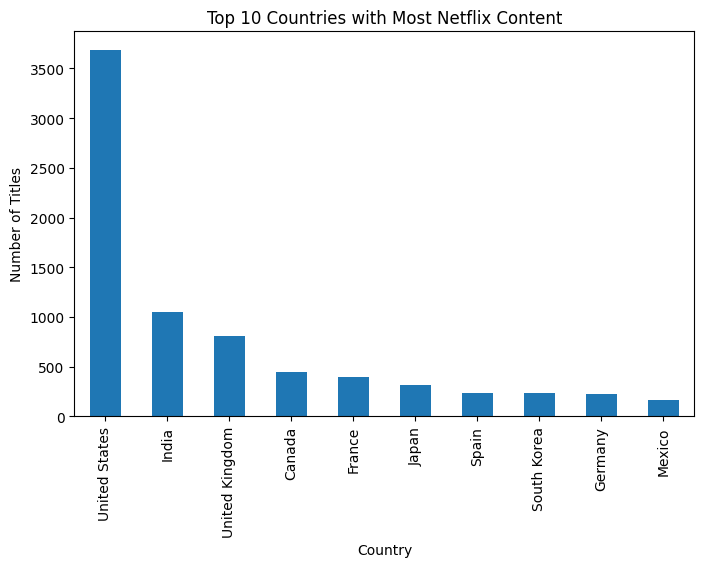

In [21]:
plt.figure(figsize=(8,5))
top_countries.plot(kind='bar')
plt.title("Top 10 Countries with Most Netflix Content")
plt.xlabel("Country")
plt.ylabel("Number of Titles")
plt.show()
